In [1]:
"""
Plot example image chunks from reference data
"""

import os, sys, time, glob
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

from fiona.crs import from_epsg
from shapely.geometry import box

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms, utils
from torchsat.models.classification import resnet18

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
print(f'Projected CRS: {proj}')

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

print("Successfully imported all packages!")

Projected CRS: EPSG:32618
Successfully imported all packages!


In [40]:
def plot_image_chunks(dataset, class_mapping, bands_to_plot, out_file, figsize=(10,10), labelsize=10):
    """
    Plots a single example image chunk for each class with columns representing different bands.
    
    Args:
    - dataset: The dataset containing the image chunks and labels.
    - class_mapping: Dictionary mapping class codes to class labels.
    - bands_to_plot: List of band indices to plot, or 'all' to plot every band in the dataset.
    """
    # Determine which bands to plot
    first_batch = next(iter(dataset))
    num_bands = first_batch['image'].shape[1] if bands_to_plot == 'all' else len(bands_to_plot)
    
    if bands_to_plot == 'all':
        bands_to_plot = list(range(num_bands))
    
    codes = list(class_mapping.values())
    classes = list(class_mapping.keys())
    
    # Store examples for each class
    samples_dict = {cls: None for cls in codes}
    
    # Iterate over the DataLoader to find at least one sample for each class
    for batch in dataset:
        images, labels = batch['image'], batch['code']
        
        for i, cls in enumerate(codes):
            if samples_dict[cls] is None:  # If no sample has been found for this class yet
                cls_indices = (labels == cls).nonzero(as_tuple=True)[0]
                if len(cls_indices) > 0:
                    idx = cls_indices[0]  # Take the first available sample
                    samples_dict[cls] = images[idx].numpy()
        
        # Break if samples for all classes have been found
        if all(sample is not None for sample in samples_dict.values()):
            break
    
    # Plot the collected samples
    fig, axes = plt.subplots(len(codes), num_bands, figsize=figsize, squeeze=False)
    
    for i, cls in enumerate(codes):
        image = samples_dict[cls]
        if image is None:
            print(f"No samples available for class {cls}.")
            continue
        
        for b, band_idx in enumerate(bands_to_plot):
            band_image = image[band_idx, :, :]  # Select the specific band
            axes[i, b].imshow(band_image, cmap='gray')  # Use grayscale for single-band images
            axes[i, b].axis('off')
            
            # Add title for the first row of each band
            if i == 0:
                axes[i, b].set_title(f"{band_mapping[b+1]}", fontsize=labelsize)
            
            # Add class label as y-axis title for the first column
            if b == 0:
                class_label = classes[i]
                axes[i, b].set_ylabel(class_label, fontsize=labelsize, rotation=0, labelpad=40, va='center', ha='right')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    plt.savefig(out_file, dpi=300, bbox_inches='tight')
    plt.show()

print("Plotting function ready !!!")

Plotting function ready !!!


In [4]:
# Load the reference data
ref_fp = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
ref = gpd.read_file(ref_fp)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [33]:
# Create a numeric class code 
ref['code'], _ = pd.factorize(ref['class_code'])
# Create a dictionary mapping class_code to code
class_mapping = dict(zip(ref['class_code'], ref['code']))
print(class_mapping)

{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WS': 5, 'SH': 6}


In [6]:
# Identify areas with "pure" material types for examples

In [7]:
# Create centroids
ref_pt = ref.copy()
ref_pt = ref_pt.to_crs(epsg=32618)
ref_pt['geometry'] = ref_pt['geometry'].centroid

# Define the window size and half window (for boxes)
window_size = 144 # 4 * average side length (relative neighbors (?))
half_window = window_size / 2

training_windows = [] # image windows with >50% of specific roof type
training_roof_types = [] # roof type codes for valid windows

# Loop through each footprint individually
for geom, roof_type in zip(ref.geometry, ref['class_code']):
    # calculate the image window as footprint buffer
    centroid = geom.centroid
    window = box(centroid.x - half_window, centroid.y - half_window,
                 centroid.x + half_window, centroid.y + half_window)

    # Intersect with centroids to get class count within window
    intersect = ref_pt[ref_pt.intersects(window)]
    
    # Get the total count and count for the class
    total_count = len(intersect)
    class_count = len(intersect[intersect['class_code'] == roof_type])

    # Check if there is at least 50% of the roof type in that window
    if total_count > 0 and (class_count / total_count) > 0.50:
        training_windows.append(geom)
        training_roof_types.append(roof_type)

    del intersect, window, centroid

# Create a GeoDataFrame for the training windows with roof types
ref_windows = gpd.GeoDataFrame({
    'geometry': training_windows, 
    'class_code': training_roof_types
}, crs=ref.crs)

# Create a numeric code for the training data frame
ref_windows['code'], _ = pd.factorize(ref_windows['class_code'])
print("Spatial filtering complete.")

Spatial filtering complete.


In [8]:
ref_windows.class_code.value_counts()

class_code
ME    34130
CS    31057
SL     9680
WS      179
UR      107
TL       84
SH        7
Name: count, dtype: int64

In [9]:
# Perform balanced sampling (random undersampling)
ref_bal = balance_sampling(ref_windows, ratio=50, strategy='undersample')
ref_bal.class_code.value_counts()

class_code
ME    350
CS    350
SL    350
WS    179
UR    107
TL     84
SH      7
Name: count, dtype: int64

In [10]:
# Load the image data

In [11]:
# Load the image stack
stack_da_fp = os.path.join(maindir, 'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()

# Extract band names
band_desc = stack_da.attrs['long_name']
band_idx = stack_da.band.values
n_bands = len(band_desc)

# Create the dictionary mapping long names to band numbers
band_mapping = dict(zip(band_idx, band_desc))
print(band_mapping)

{1: 'nir', 2: 'NDBIbg', 3: 'NDBIrg', 4: 'NISI', 5: 'MNF1', 6: 'NISI5x5'}


In [14]:
# Create a DataLoader

# Extract image chunks and labels
image_ds = RoofImageDatasetPlanet(
    ref_bal[['geometry', 'code']], img_path=stack_da_fp, img_dim=144, n_bands=n_bands
)

# Ensure all samples are available
bs = len(image_ds)

# Load the Dataset
da_loader = DataLoader(
    image_ds, 
    batch_size=bs, 
    shuffle=True, 
)
print("Data loaded!")

Data loaded!


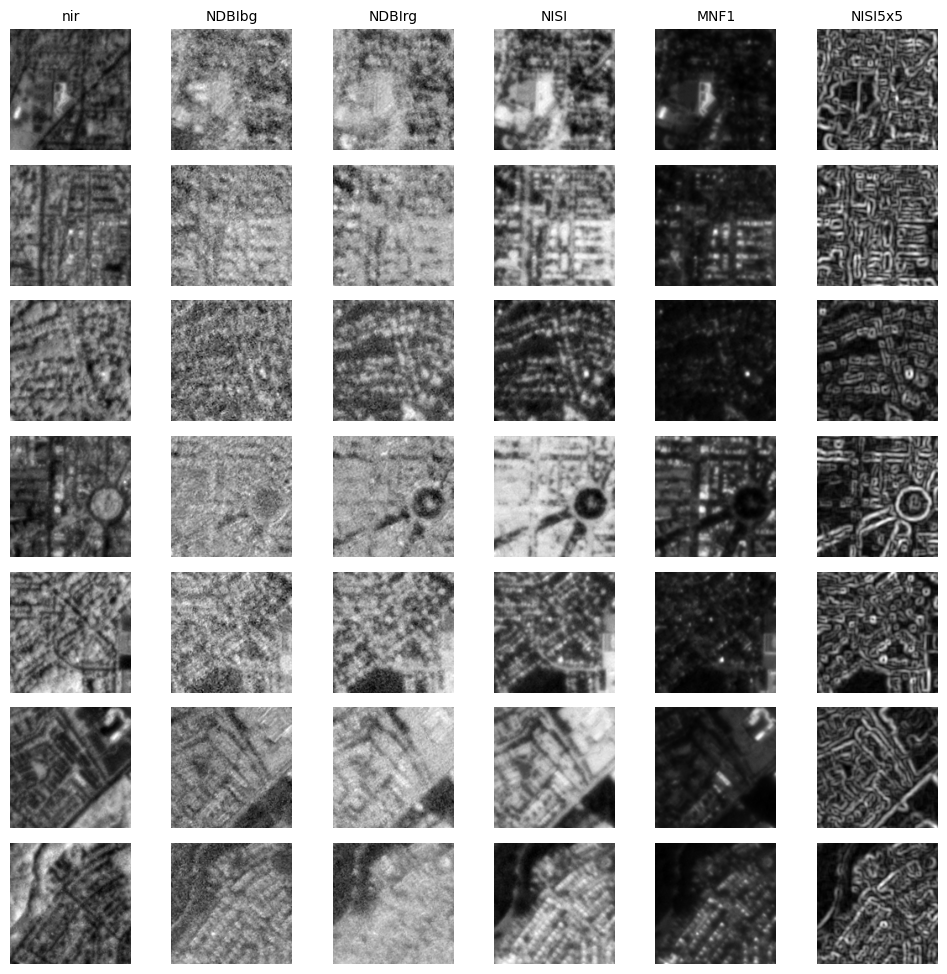

In [41]:
# Create a plot of image chunks
out_png = os.path.join(maindir,'figures/FigX_dc_image_chunks.png')
plot_image_chunks(da_loader, class_mapping, bands_to_plot='all', out_file=out_png)

In [ ]:
# def plot_example_chunks(dataset, class_mapping, num_examples=3):
#     """
#     Plots example image chunks for each class.
    
#     Args:
#     - dataset: The dataset containing the image chunks and labels.
#     - class_mapping: Dictionary mapping class codes to class labels.
#     - num_examples: Number of examples to plot for each class.
#     """
    
#     classes = list(class_mapping.keys())
#     fig, axes = plt.subplots(len(classes), num_examples, figsize=(10,10))
#     # fig.suptitle("Example Image Chunks for Each Roof Class", fontsize=16)

#     for i, cls in enumerate(classes):
#         cls_indices = [j for j, x in enumerate(dataset.Y) if x == cls]
        
#         if len(cls_indices) < num_examples:
#             print(f"Not enough samples for class {cls}. Available samples: {len(cls_indices)}")
#             continue
        
#         selected_indices = np.random.choice(cls_indices, num_examples, replace=False)

#         for k, idx in enumerate(selected_indices):
#             sample = dataset[idx]
#             if sample is None:
#                 print(f"Skipping invalid sample at index {idx}")
#                 continue
#             image = sample['image'].permute(1, 2, 0).numpy()  # Change the dimensions to HWC for plotting
            
#             # Scale the image to [0, 255] range for display
#             image = (255 * (image - image.min()) / (image.max() - image.min())).astype(np.uint8)
            
#             axes[i, k].imshow(image)
#             axes[i, k].set_title(class_mapping[cls] if k == 0 else '')  # Title only on the first column
#             axes[i, k].axis('off')

#     plt.tight_layout()
#     plt.subplots_adjust(top=0.95)

#     plt.savefig('image_chunks.png')
#     plt.show()
    

# print("Class and functions ready to use!")

In [13]:
# # Load our image data to check on the format
# rgb = rxr.open_rasterio(rgb_image_path, masked=True, cache=False).squeeze()
# print_raster(rgb, open_file=False)
# band_names = rgb.long_name
# del stack_da

In [12]:
# # Select the red, green, and blue bands
# red_band = stack_da[band_dict['red'] - 1]  # subtract 1 because xarray is 0-indexed
# green_band = stack_da[band_dict['green'] - 1]
# blue_band = stack_da[band_dict['blue'] - 1]

# # Stack the selected bands into an RGB image
# rgb_image = np.stack([red_band, green_band, blue_band], axis=0)

# # Save the RGB image
# rgb_image_path = os.path.join(maindir, 'data/spatial/mod/dc_data/planet-data/dc_data_psscene_rgb.tif')

# # Define the metadata including the long_name attribute
# metadata = {
#     'driver': 'GTiff',
#     'height': rgb_image.shape[1],
#     'width': rgb_image.shape[2],
#     'count': 3,
#     'dtype': rgb_image.dtype,
#     'crs': stack_da.rio.crs,
#     'transform': stack_da.rio.transform(),
#     'compress': 'lzw'
# }

# with rio.open(rgb_image_path, 'w', **metadata) as dst:
#     dst.write(rgb_image)
#     dst.set_band_description(1, 'red')
#     dst.set_band_description(2, 'green')
#     dst.set_band_description(3, 'blue')
    
# print("RGB image saved successfully!")

In [ ]:
# # Create a plot of example image chunks (RGB)

# # Ensure that train_df and other DataFrames have the numeric codes
# ref['code'], class_mapping = pd.factorize(ref['class_code'])
# class_mapping = dict(enumerate(class_mapping))
# print("Class mapping:", class_mapping)

# # Ensure train_df has the numeric codes
# train_df = train_df.dropna(subset=['class_code'])
# train_df['code'] = train_df['class_code'].map(lambda x: list(class_mapping.keys())[list(class_mapping.values()).index(x)])
# val_df['code'] = val_df['class_code'].map(lambda x: list(class_mapping.keys())[list(class_mapping.values()).index(x)])
# test_df['code'] = test_df['class_code'].map(lambda x: list(class_mapping.keys())[list(class_mapping.values()).index(x)])

# # Verify the mapping
# print("Train DataFrame head:")
# print(train_df.head())
# print("Validation DataFrame head:")
# print(val_df.head())
# print("Test DataFrame head:")
# print(test_df.head())

# # Plot example chunks
# plot_example_chunks(train_ds, class_mapping, num_examples=3)